# Import modules

In [1]:
import numpy as np
import pandas as pd
import os,cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.utils import shuffle
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import keras

from keras.utils import np_utils
#Input data files are available in the "../input/" directory

import random
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Activation,Dropout,Flatten,Input,SeparableConv2D,GlobalAveragePooling2D,concatenate
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers import RMSprop,Adam,SGD,Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.layers import BatchNormalization
import os

#Any results you write to the directory are saved as output

from sklearn.model_selection import cross_val_score,cross_val_predict
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from sklearn.datasets import make_classification
from tensorflow.keras import regularizers

from tensorflow.keras.applications import VGG16
from keras.applications.nasnet import NASNetLarge

import skimage.io
import keras.backend as K

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
np.random.seed(42)

# Load and explore the dataset

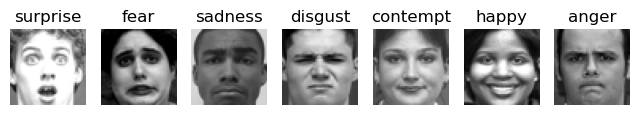

In [3]:
i=1
plt.figure(figsize=(8,8))
for expression in os.listdir('/kaggle/input/ckplus/CK+48/'):
    img=load_img(('/kaggle/input/ckplus/CK+48/'+expression+'/'+os.listdir('/kaggle/input/ckplus/CK+48/'+expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i+=1
plt.show()

In [4]:
#Check the amount of data in each folder in training dataset
for expression in os.listdir('/kaggle/input/ckplus/CK+48/'):
    print(expression,'folder contains\t\t',len(os.listdir('/kaggle/input/ckplus/CK+48/'+expression)),'images')

surprise folder contains		 249 images
fear folder contains		 75 images
sadness folder contains		 84 images
disgust folder contains		 177 images
contempt folder contains		 54 images
happy folder contains		 207 images
anger folder contains		 135 images


In [5]:
data_dir='/kaggle/input/ckplus/CK+48/'

In [6]:
categories=os.listdir(data_dir)
categories

['surprise', 'fear', 'sadness', 'disgust', 'contempt', 'happy', 'anger']

In [7]:
def load_data():
    data_dir=r'/kaggle/input/ckplus/CK+48/'
    data=[]
    #loading data
    for category in categories:
        #create path to image of respective expression
        path=os.path.join(data_dir,category)
        #get the classification for each category
        class_num=categories.index(category)
        
        for img in tqdm(os.listdir(path)):
            img_array=cv2.imread(os.path.join(path,img),0)
            data.append([img_array,class_num])
            
    return data

In [8]:
data=load_data()

100%|██████████| 135/135 [00:00<00:00, 244.56it/s]


In [9]:
len(data)

981

# Creating training and testing data

In [10]:
X=np.array([x[0] for x in data])
y=np.array([Y[1] for Y in data])

In [11]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,shuffle=True)

In [12]:
print('X_train shape: ',X_train.shape)
print('y_train shape: ',y_train.shape)
print('----------------------------')
print('X_test shape: ',X_test.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (784, 48, 48)
y_train shape:  (784,)
----------------------------
X_test shape:  (197, 48, 48)
y_test shape:  (197,)


In [13]:
#reshaping y_train and y_test
y_train=np.reshape(y_train,(len(y_train),1))
y_test=np.reshape(y_test,(len(y_test),1))

print('After reshaping')
print('y_train shape: ',y_train.shape)
print('y_test shape: ',y_test.shape)

After reshaping
y_train shape:  (784, 1)
y_test shape:  (197, 1)


In [14]:
X_train_Gabor=X_train
X_test_Gabor=X_test

**Adding color channel**

In [15]:
X_train=np.expand_dims(X_train,axis=3)
X_test=np.expand_dims(X_test,axis=3)

print('After adding color channel')
print("X_train shape: ",X_train.shape)
print("X_test shape: ",X_test.shape)

After adding color channel
X_train shape:  (784, 48, 48, 1)
X_test shape:  (197, 48, 48, 1)


**Normalizing pixel values**    

In [16]:
X_train=X_train/255.0
X_test=X_test/255.0

**Converting single values to category array**

In [17]:
y_train[0]

array([6])

In [18]:
y_train_SVM=y_train
y_test_SVM=y_test

y_train=tf.keras.utils.to_categorical(y_train)
y_test=tf.keras.utils.to_categorical(y_test)

In [19]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [20]:
y_train.shape,y_test.shape

((784, 7), (197, 7))

# Feature Extraction

# **HOG Technique**

In [21]:
from skimage.transform import resize
from skimage.feature import hog

(-0.5, 47.5, 47.5, -0.5)

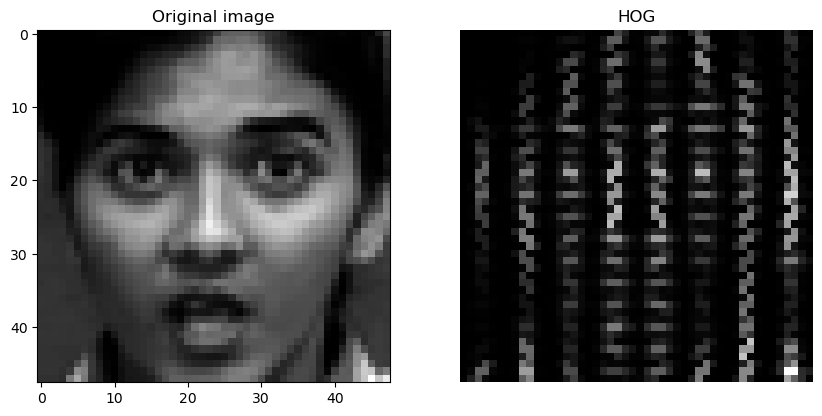

In [22]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
img=random.choice(X_train)
#first image needs to be resized before passing it to HOG descriptor
resized_img=resize(img,(128,64))
plt.title('Original image')
plt.imshow(img,cmap='gray')
fd,hog_image=hog(
    resized_img,
    orientations=9,
    pixels_per_cell=(8,8),
    cells_per_block=(2,2),
    visualize=True,
    channel_axis=-1
)
plt.subplot(1,2,2)
plt.title("HOG")
plt.imshow(resize(hog_image,(48,48)),cmap='gray')
plt.axis('off')

**Create feature vectors for training and testing**

In [23]:
def create_HOG_features(data):
    Feature_data=np.zeros((len(data),48,48))
    
    for i in range(len(data)):
        img=data[i]
        resized_img=resize(img,(128,64))
        fd,hog_image=hog(
           resized_img,
           orientations=9,
           pixels_per_cell=(8,8),
           cells_per_block=(2,2),
           visualize=True,
           channel_axis=-1
        )
        Feature_data[i]=resize(hog_image,(48,48))
    return Feature_data

In [24]:
Feature_X_train=create_HOG_features(X_train)
Feature_X_train.shape

(784, 48, 48)

(-0.5, 47.5, 47.5, -0.5)

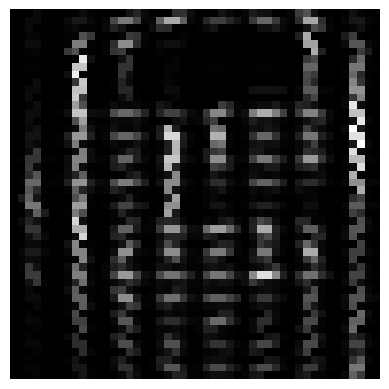

In [25]:
plt.imshow(random.choice(Feature_X_train),cmap='gray')
plt.axis('off')

In [26]:
#doing same for test data
Feature_X_test=create_HOG_features(X_test)
Feature_X_test.shape

(197, 48, 48)

(-0.5, 47.5, 47.5, -0.5)

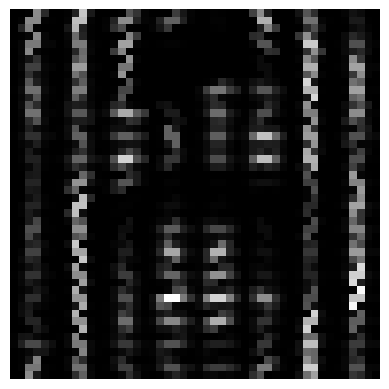

In [27]:
plt.imshow(random.choice(Feature_X_test),cmap='gray')
plt.axis('off')

In [28]:
#Adding again color channel as it got removed while converting img to hog img
X_train_HOG=np.expand_dims(Feature_X_train,axis=3)
X_test_HOG=np.expand_dims(Feature_X_test,axis=3)

print('After adding color channel')
print("X_train_HOG shape: ",X_train_HOG.shape)
print("X_test_HOG shape: ",X_test_HOG.shape)

After adding color channel
X_train_HOG shape:  (784, 48, 48, 1)
X_test_HOG shape:  (197, 48, 48, 1)


In [29]:
print("X_train_HOG shape: ",X_train_HOG.shape)
print("y_train shape: ",y_train.shape)
print("X_test_HOG shape: ",X_test_HOG.shape)
print("y_test shape: ",y_test.shape)

X_train_HOG shape:  (784, 48, 48, 1)
y_train shape:  (784, 7)
X_test_HOG shape:  (197, 48, 48, 1)
y_test shape:  (197, 7)


**Training and Testing the HOG-CNN model**

In [30]:
def create_model(input_shape=None):
    if input_shape is None:
        input_shape=(48,48,1)
        
#     model=Sequential()
#     model.add(Conv2D(6,(5,5),input_shape=input_shape,padding='same',activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2,2)))
    
#     model.add(Conv2D(16,(5,5),padding='same',activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2,2)))
    
#     model.add(Conv2D(64,(3,3),activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2,2)))
    
# #     model.add(Conv2D(128,(3,3),activation='relu'))
# #     model.add(MaxPooling2D(pool_size=(2,2)))
    
# #     model.add(Conv2D(64,(3,3),activation='relu'))
# #     model.add(MaxPooling2D(pool_size=(2,2)))
    
#     model.add(Flatten())
#     model.add(Dense(128,activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(7,activation='softmax'))

    inputs=Input(shape=input_shape)

    
    h=Conv2D(32,(1,1),padding='same',activation='relu')(inputs)
    h=BatchNormalization()(h)
#     h=tf.nn.relu(h)
    h=Conv2D(48,(3,3))(h)
    h=BatchNormalization()(h)
#     h=MaxPooling2D((2,2),strides=(2,2))(h)\
    h=Activation('relu')(h)

    b=Conv2D(128,(1,1),strides=(2,2))(h)
    b=BatchNormalization()(b)

    h=SeparableConv2D(128,(3,3),padding='same')(h)
    h=BatchNormalization()(h)
#     h=tf.nn.relu(h)
    h=Activation('relu')(h)
    h=SeparableConv2D(128,(3,3),padding='same')(h)
    h=BatchNormalization()(h)
    h=MaxPooling2D((2,2),strides=(2,2))(h)

    h=concatenate([h,b],name='first')

    b=Conv2D(128,(2,2),strides=(2,2))(h)
    b=BatchNormalization()(b)

    h=SeparableConv2D(128,(3,3),padding='same')(h)
    h=BatchNormalization()(h)
#     h=tf.nn.relu(h)
#     h=SeparableConv2D(128,(3,3),padding='same')(h)
#     h=BatchNormalization()(h)
    h=MaxPooling2D((2,2),strides=(2,2))(h)

    h=concatenate([h,b],name='second')

    b=Conv2D(128,(1,1),padding='same')(h)
    b=BatchNormalization()(b)
    b=MaxPooling2D((2,2),strides=(2,2))(b)

    h=SeparableConv2D(256,(3,3),padding='same')(h)
    h=BatchNormalization()(h)
#     h=tf.nn.relu(h)
    h=Activation('relu')(h)
    h=SeparableConv2D(256,(3,3),padding='same')(h)
    h=BatchNormalization()(h)
    h=MaxPooling2D((2,2),strides=(2,2))(h)

    h=concatenate([h,b],name='third')
    b=h

#     h=tf.nn.relu(h)
    h=SeparableConv2D(512,(3,3),padding='same')(h)
    h=BatchNormalization()(h)
#     h=tf.nn.relu(h)
    h=SeparableConv2D(512,(3,3),padding='same')(h)
    h=BatchNormalization()(h)
#     h=tf.nn.relu(h)
    h=SeparableConv2D(512,(3,3),padding='same')(h)
    h=BatchNormalization()(h)

    h=concatenate([h,b],name='fourth')

    b=Conv2D(512,(1,1),padding='same')(h)
    b=BatchNormalization()(b)
    b=MaxPooling2D((2,2),strides=(2,2))(b)

    h=SeparableConv2D(512,(3,3),padding='same')(h)
    h=BatchNormalization()(h)
#     h=tf.nn.relu(h)
    h=SeparableConv2D(512,(3,3),padding='same')(h)
    h=BatchNormalization()(h)
    h=MaxPooling2D((2,2),strides=(2,2))(h)

    h=concatenate([h,b],name='fifth')

    b=Conv2D(512,(1,1),padding='same')(h)
    b=BatchNormalization()(b)
    b=MaxPooling2D((2,2),strides=(2,2))(b)

    h=SeparableConv2D(512,(3,3),padding='same')(h)
    h=BatchNormalization()(h)
#     h=tf.nn.relu(h)
    h=SeparableConv2D(512,(3,3),padding='same')(h)
    h=BatchNormalization()(h)
    h=MaxPooling2D((2,2),strides=(2,2))(h)

    h=concatenate([h,b],name='sixth')
    b=h


#     h=tf.nn.relu(h)

    h=SeparableConv2D(512,(3,3),padding='same')(h)
    h=BatchNormalization()(h)
#     h=tf.nn.relu(h)
    h=SeparableConv2D(256,(3,3),padding='same')(h)
    h=BatchNormalization()(h)
#     h=tf.nn.relu(h)
    h=SeparableConv2D(256,(3,3),padding='same')(h)
    h=BatchNormalization()(h)

    h=concatenate([h,b],name='seventh')
    b=h

    b=Conv2D(256,(1,1),strides=(1,1))(h)
    b=BatchNormalization()(b)

#     h=tf.nn.relu(h)
    h=SeparableConv2D(512,(3,3),padding='same')(h)
    h=BatchNormalization()(h)
#     h=tf.nn.relu(h)
    h=SeparableConv2D(512,(3,3),padding='same')(h)
    h=BatchNormalization()(h)

    h=concatenate([h,b],name='eighth')

    h=SeparableConv2D(256,(3,3),padding='same')(h)
    h=BatchNormalization()(h)
#     h=tf.nn.relu(h)

    h=GlobalAveragePooling2D()(h)

    h=Dense(128,activation='relu')(h)
    h=Dropout(0.4)(h)
    h=Dense(64,activation='relu')(h)
    h=Dropout(0.3)(h)
    h=Dense(7,activation='softmax')(h)
    
    outputs=h
    
    model=Model(inputs,outputs)
    
    return model

In [31]:
es=EarlyStopping(
    monitor='val_accuracy',min_delta=0.0001,patience=10,verbose=2,mode='max',baseline=None,restore_best_weights=True
)
lr=ReduceLROnPlateau(
    monitor='val_accuracy',factor=0.1,patience=5,verbose=2,mode='max',min_delta=0.007,cooldown=0,min_lr=0
)
callbacks=[es,lr]

In [32]:
HOG_model=create_model()

In [33]:
HOG_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 32)   64          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 48, 48, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 46, 46, 48)   13872       ['batch_normalization[0][0]']

**Model Visualization**

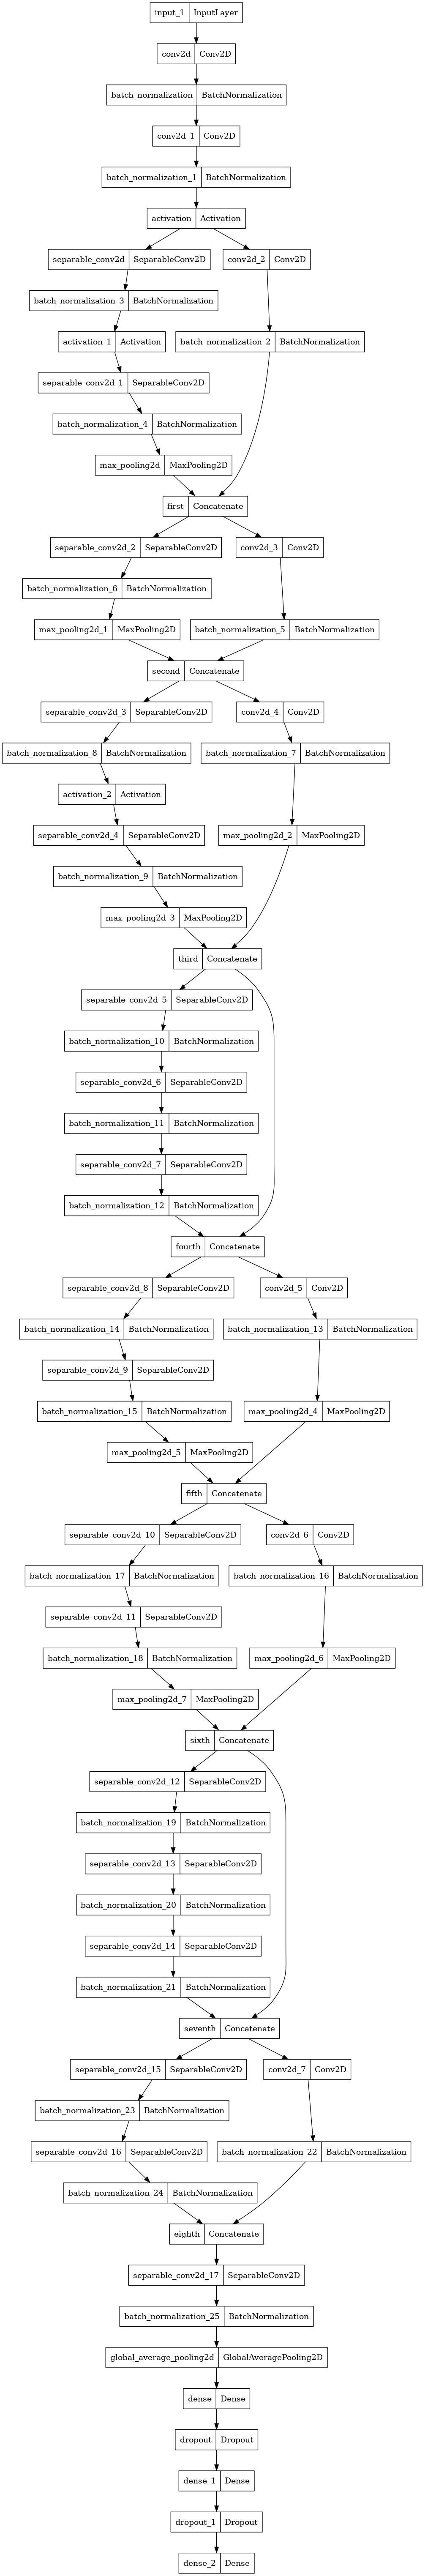

In [34]:
from keras.utils import plot_model
plot_model(HOG_model,to_file='HOG_model.png')

In [35]:
HOG_model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [36]:
HOG_history=HOG_model.fit(X_train_HOG,y_train,batch_size=8,epochs=50,validation_data=(X_test_HOG,y_test),callbacks=[callbacks])

Epoch 1/50
98/98 [==============================] - 32s 34ms/step - loss: 1.4748 - accuracy: 0.5089 - val_loss: 1.9482 - val_accuracy: 0.0914 - lr: 0.0010
Epoch 2/50
98/98 [==============================] - 2s 21ms/step - loss: 1.1889 - accuracy: 0.6071 - val_loss: 1.9547 - val_accuracy: 0.2132 - lr: 0.0010
Epoch 3/50
98/98 [==============================] - 2s 21ms/step - loss: 0.9722 - accuracy: 0.6735 - val_loss: 2.0021 - val_accuracy: 0.2132 - lr: 0.0010
Epoch 4/50
98/98 [==============================] - 2s 20ms/step - loss: 0.9148 - accuracy: 0.6849 - val_loss: 2.0278 - val_accuracy: 0.1066 - lr: 0.0010
Epoch 5/50
98/98 [==============================] - 2s 24ms/step - loss: 0.7374 - accuracy: 0.7449 - val_loss: 2.1757 - val_accuracy: 0.0711 - lr: 0.0010
Epoch 6/50
98/98 [==============================] - 2s 23ms/step - loss: 0.7253 - accuracy: 0.7513 - val_loss: 1.1456 - val_accuracy: 0.6294 - lr: 0.0010
Epoch 7/50
98/98 [==============================] - 2s 22ms/step - loss: 0.

In [37]:
def plot_performance(history):
    plt.figure(figsize=(12,8))
    
    plt.subplot(2,1,1)
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='val')
    
    plt.legend()
    plt.grid()
    plt.title('train and val loss evolution')
    
    plt.subplot(2,1,2)
    plt.plot(history.history['accuracy'],label='train')
    plt.plot(history.history['val_accuracy'],label='val')
    
    plt.legend()
    plt.grid()
    plt.title('train and val accuracy')

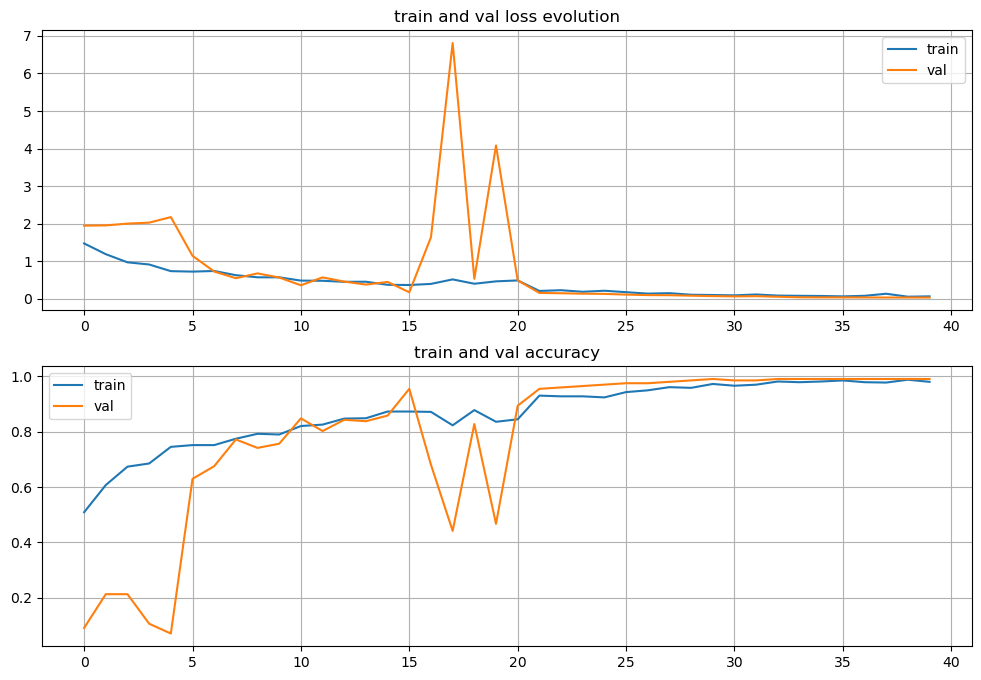

In [38]:
plot_performance(HOG_history)

In [39]:
acc=[]

In [40]:
HOG_acc=HOG_model.evaluate(X_test_HOG,y_test,verbose=0)[1]
acc.append(HOG_acc)
print("HOG Accuracy : ",HOG_model.evaluate(X_test_HOG,y_test,verbose=0)[1])

HOG Accuracy :  0.989847719669342


In [41]:
HOG_model.save('HOG_model.h5')

# LBP Technique

In [42]:
def Binarypattern(im): #Creating function to get local binary pattern
    img=np.zeros_like(im)
    n=3   #taking kernel of size 3x3
    for i in range(0,im.shape[0]-n): #for image height
        for j in range(0,im.shape[1]-n): #for image width
            x=im[i:i+n,j:j+n] #reading the entire image in 3x3 format
            center=x[1,1] #taking the center value for 3x3 kernel
            img1=(x>=center)*1.0 #checking if neighbouring values of center value is greater or less than the center value
            img1_vector=img1.T.flatten() #getting the image pixel values
            img1_vector=np.delete(img1_vector,4)
            digit=np.where(img1_vector)[0]
            if len(digit)>=1: #converting the neighbouring pixels according to center pixel value
                num=np.sum(2**digit) #if n>center assign 1 and if n<center assign 0
            else: #if 1 then multiply by 2^digit and if 0 then making value 0 and aggregating all the values of kernel to get new center value
                num=0
            img[i+1,j+1]=num
    return(img)     

**LBP looks like....**

In [43]:
# !pip install matplotlib

In [44]:
import matplotlib.pyplot as plt
# import cv2_imshow

In [45]:
# img=random.choice(X_train)
# img=cv2.imread(img)
# gray_img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# cv2_imshow(gray_img)

In [46]:
# imgLBP=Binarypattern(gray_img) #calling the LBP function using the gray image
# vectorLBP=imgLBP.flatten() #for histogram using the vector form of image pixels
# fig=plt.figure(figsize=(20,8)) #subplotting the gray,LBP and histogram
# ax=fig.add_subplot(1,3,1)
# ax.imshow(gray_img)
# ax.set_title("gray scale image")
# ax=fig.add_subplot(1,3,2)
# ax.imshow(imgLBP,cmap='gray')
# ax.set_title("LBP converted image")
# ax=fig.add_subplot(1,3,3)
# freq,lbp,_=ax.hist(vectorLBP,bins=2**8)
# ax.set_ylim(0,40000)
# lbp=lbp[:-1]
# #print the LBP values when frequencies are high
# largeTF=freq>5000
# for x,fr in zip(lbp[largeTF],freq[largeTF]):
#     ax.text(x,fr,"{:6.0f}".format(x),color="magenta")
# ax.set_title("LBP histogram")
# plt.show()

(-0.5, 47.5, 47.5, -0.5)

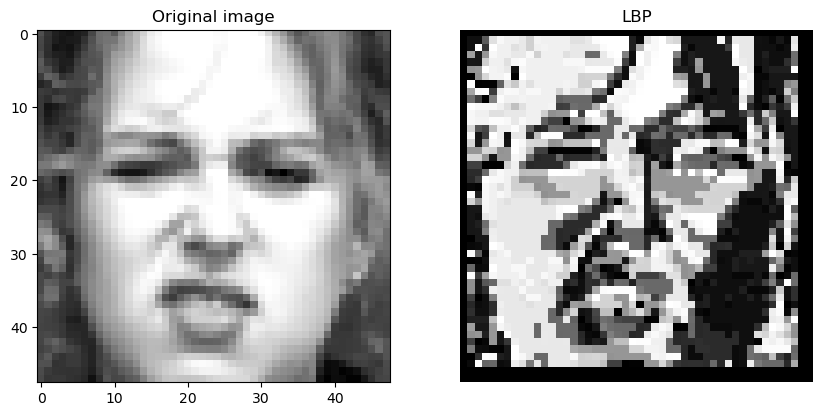

In [47]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
img=random.choice(X_train)
plt.title('Original image')
plt.imshow(img,cmap='gray')

plt.subplot(1,2,2)
plt.title("LBP")
imgLBP=Binarypattern(img) #calling the LBP function using gray image
plt.imshow(imgLBP,cmap='gray')
plt.axis('off')

**Create feature vectors for training and testing**

In [48]:
X_train.shape

(784, 48, 48, 1)

In [49]:
def create_LBP_features(data):
    Feature_data=np.zeros(data.shape)
    
    for i in range(len(data)):
        img=data[i]
        imgLBP=Binarypattern(img)
        Feature_data[i]=imgLBP
        
    return Feature_data

In [50]:
Feature_X_train=create_LBP_features(X_train)

In [51]:
Feature_X_train.shape

(784, 48, 48, 1)

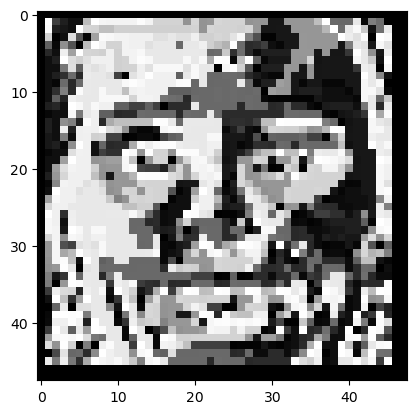

In [52]:
img=random.choice(Feature_X_train)
plt.imshow(img,cmap='gray')

In [53]:
Feature_X_test=create_LBP_features(X_test)
Feature_X_test.shape

(197, 48, 48, 1)

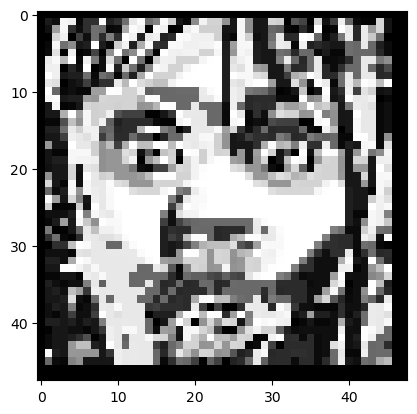

In [54]:
img=random.choice(Feature_X_test)
plt.imshow(img,cmap='gray')

**Training and testing LBP-CNN model**

In [55]:
LBP_model=create_model()
LBP_model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [56]:
LBP_history=LBP_model.fit(Feature_X_train,y_train,batch_size=8,epochs=50,validation_data=(Feature_X_test,y_test),callbacks=[callbacks])

Epoch 1/50
98/98 [==============================] - 24s 29ms/step - loss: 1.5056 - accuracy: 0.4643 - val_loss: 1.9271 - val_accuracy: 0.1878 - lr: 0.0010
Epoch 2/50
98/98 [==============================] - 2s 22ms/step - loss: 1.0436 - accuracy: 0.6327 - val_loss: 1.9265 - val_accuracy: 0.1878 - lr: 0.0010
Epoch 3/50
98/98 [==============================] - 2s 22ms/step - loss: 0.7353 - accuracy: 0.7245 - val_loss: 1.9421 - val_accuracy: 0.1878 - lr: 0.0010
Epoch 4/50
98/98 [==============================] - 2s 22ms/step - loss: 0.6888 - accuracy: 0.7615 - val_loss: 2.0286 - val_accuracy: 0.1878 - lr: 0.0010
Epoch 5/50
98/98 [==============================] - 2s 21ms/step - loss: 0.5442 - accuracy: 0.8138 - val_loss: 1.9003 - val_accuracy: 0.1878 - lr: 0.0010
Epoch 6/50
98/98 [==============================] - 2s 22ms/step - loss: 0.5724 - accuracy: 0.8227 - val_loss: 0.6787 - val_accuracy: 0.7259 - lr: 0.0010
Epoch 7/50
98/98 [==============================] - 2s 22ms/step - loss: 0.

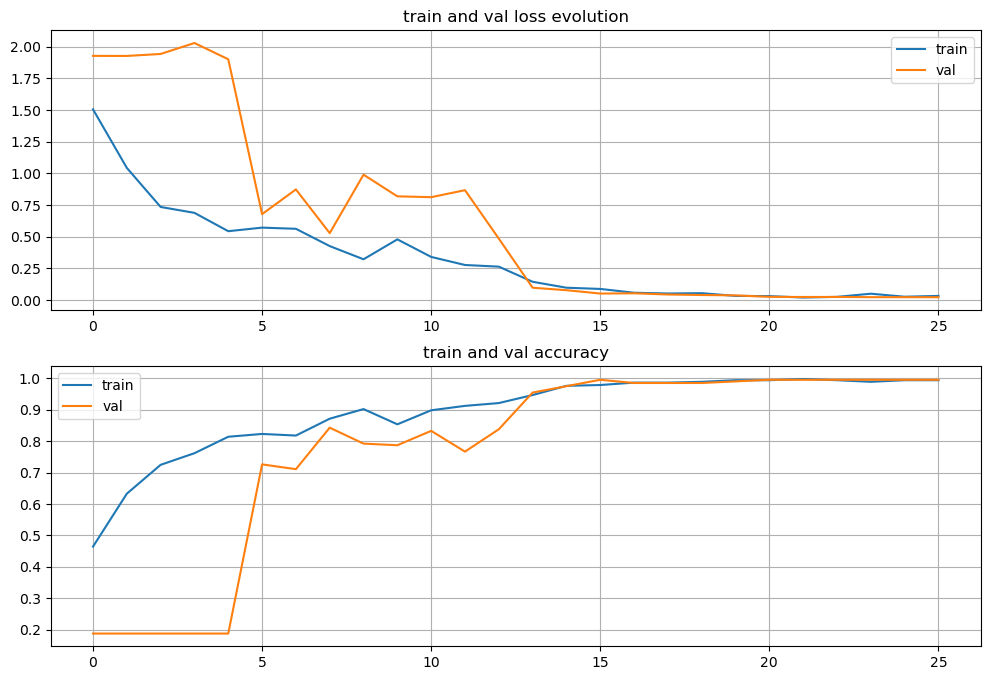

In [57]:
plot_performance(LBP_history)

In [58]:
LBP_acc=LBP_model.evaluate(Feature_X_test,y_test,verbose=0)[1]
acc.append(LBP_acc)
print("LBP Accuracy: ",LBP_model.evaluate(Feature_X_test,y_test,verbose=0)[1])

LBP Accuracy:  0.9949238300323486


In [59]:
LBP_model.save('LBP_model.h5')

# SIFT

**Let's see some sift features**

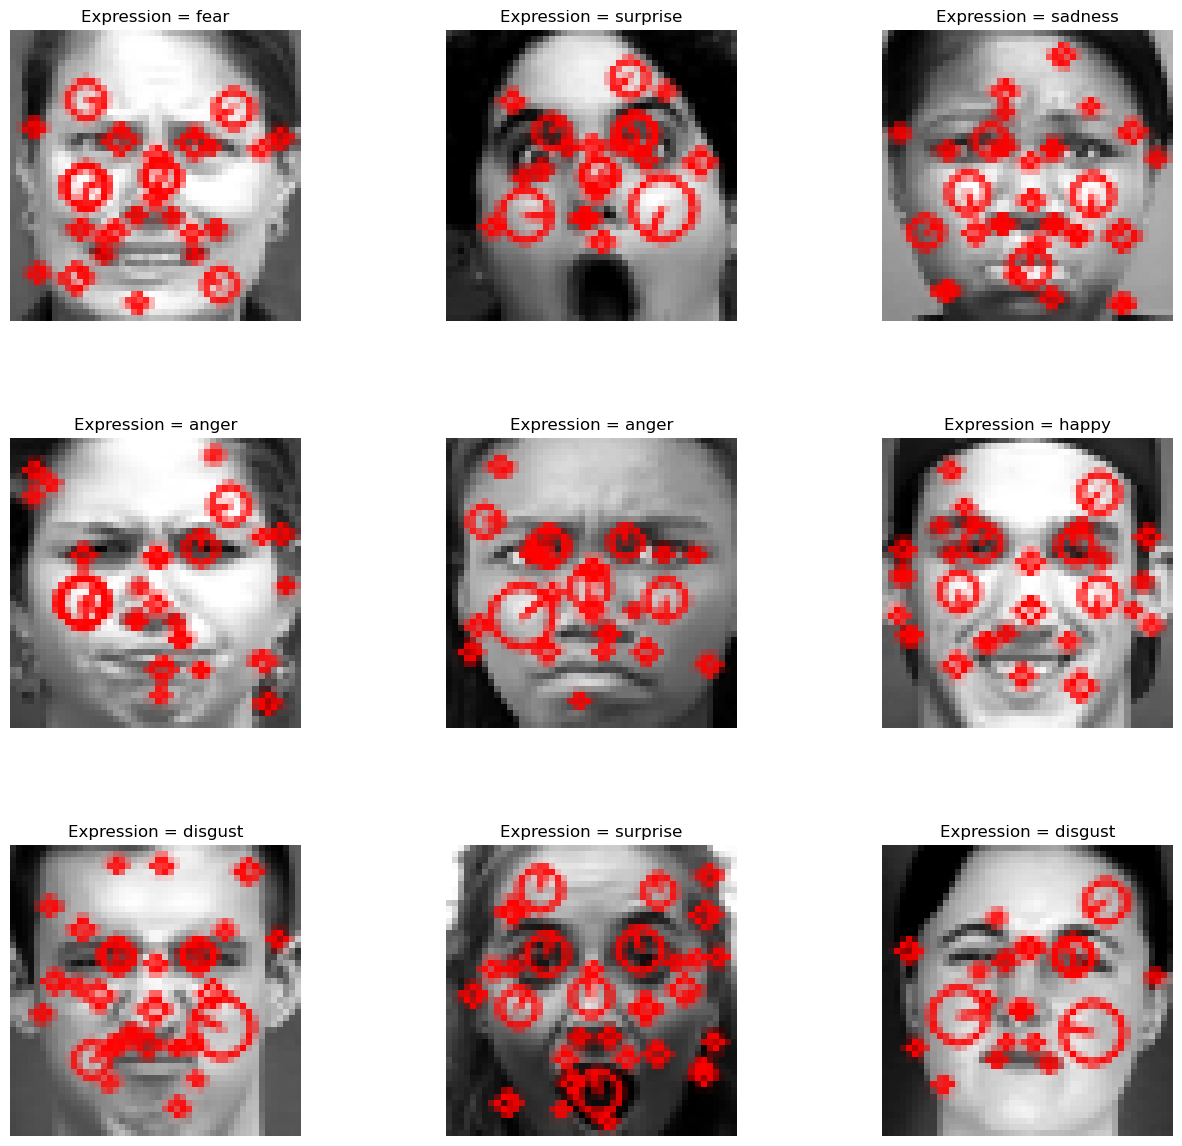

In [60]:
L=3
W=3
fig,axes=plt.subplots(L,W,figsize=(15,15))
axes=axes.ravel()

for i in range(0,L*W):
    sample=random.choice(data)
    image8bit=cv2.normalize(sample[0],None,0,255,cv2.NORM_MINMAX).astype('uint8')
    sift=cv2.SIFT_create()
    kp,des=sift.detectAndCompute(image8bit,None)
    
    img=cv2.drawKeypoints(image=image8bit,outImage=sample[0],keypoints=kp,flags=4,color=(255,0,0))
    axes[i].set_title("Expression = "+str(categories[sample[1]]))
    axes[i].imshow(img,cmap='gray')
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

In [61]:
img.shape

(48, 48, 3)

so to create a feature vector we will have to create an empty array of shape (len(data),48,48,3)

**Create feature vectors for training and testing**

In [62]:
def create_SIFT_features(data):
    Feature_data=np.zeros((len(data),48,48,3))
    
    for i in range(len(data)):
        img=data[i]
        image8bit=cv2.normalize(img,None,0,255,cv2.NORM_MINMAX).astype('uint8')
        sift=cv2.SIFT_create()
        kp,des=sift.detectAndCompute(image8bit,None)
        
        img=cv2.drawKeypoints(image=image8bit,outImage=img,keypoints=kp,flags=4,color=(255,0,0))
        Feature_data[i]=img/255.0
        
    return Feature_data

In [63]:
X_train_SIFT=create_SIFT_features(X_train)
X_train_SIFT.shape

(784, 48, 48, 3)

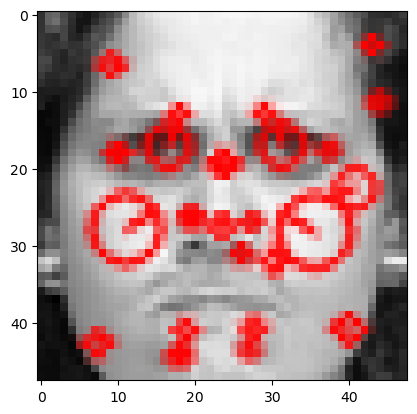

In [64]:
plt.imshow(X_train_SIFT[0],cmap='gray')

In [65]:
X_test_SIFT=create_SIFT_features(X_test)
X_test_SIFT.shape

(197, 48, 48, 3)

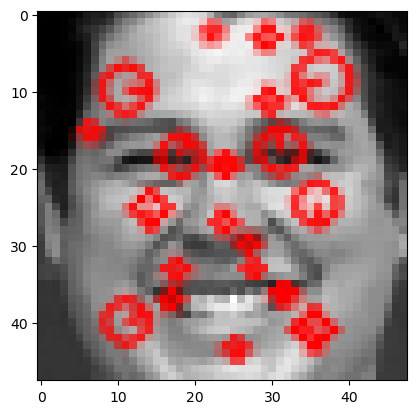

In [66]:
plt.imshow(X_test_SIFT[0],cmap='gray')

In [67]:
SIFT_model=create_model(input_shape=(48,48,3))
SIFT_model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [68]:
SIFT_history=SIFT_model.fit(X_train_SIFT,y_train,batch_size=8,epochs=50,validation_data=(X_test_SIFT,y_test),callbacks=[callbacks])

Epoch 1/50
98/98 [==============================] - 24s 30ms/step - loss: 1.8101 - accuracy: 0.3482 - val_loss: 1.9329 - val_accuracy: 0.2132 - lr: 0.0010
Epoch 2/50
98/98 [==============================] - 2s 22ms/step - loss: 1.2131 - accuracy: 0.6020 - val_loss: 1.9779 - val_accuracy: 0.0914 - lr: 0.0010
Epoch 3/50
98/98 [==============================] - 2s 20ms/step - loss: 1.0358 - accuracy: 0.6607 - val_loss: 2.0281 - val_accuracy: 0.0914 - lr: 0.0010
Epoch 4/50
98/98 [==============================] - 2s 21ms/step - loss: 0.8978 - accuracy: 0.6888 - val_loss: 2.2300 - val_accuracy: 0.0914 - lr: 0.0010
Epoch 5/50
98/98 [==============================] - 3s 28ms/step - loss: 0.7541 - accuracy: 0.7398 - val_loss: 2.1919 - val_accuracy: 0.0711 - lr: 0.0010
Epoch 6/50
98/98 [==============================] - 2s 21ms/step - loss: 0.8480 - accuracy: 0.7232 - val_loss: 1.2066 - val_accuracy: 0.5228 - lr: 0.0010
Epoch 7/50
98/98 [==============================] - 2s 21ms/step - loss: 0.

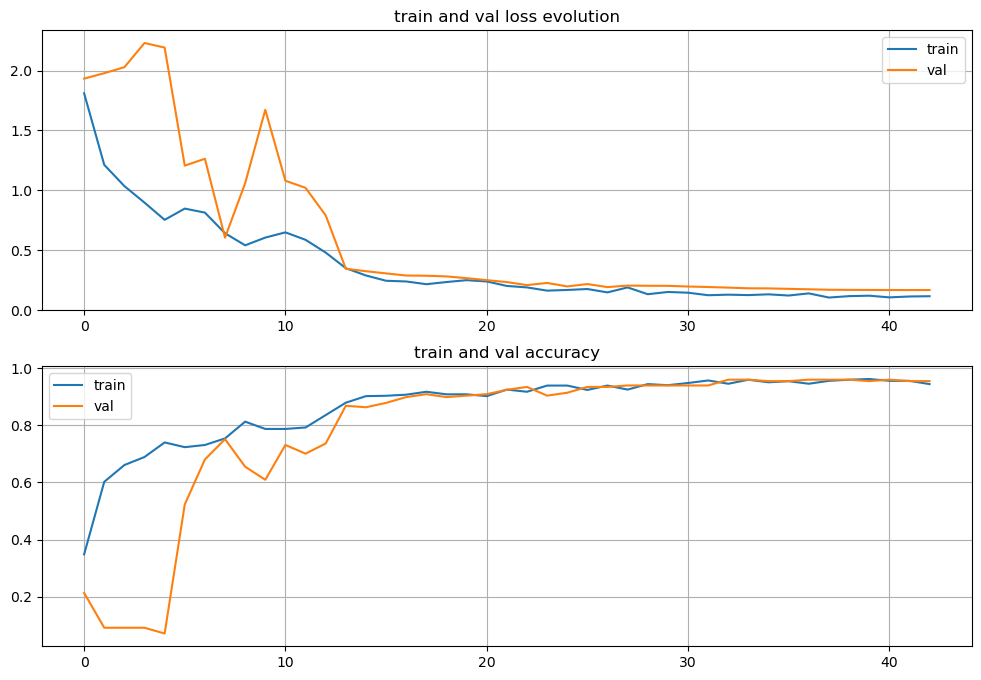

In [69]:
plot_performance(SIFT_history)

In [70]:
SIFT_acc=SIFT_model.evaluate(X_test_SIFT,y_test,verbose=0)[1]
acc.append(SIFT_acc)
print("SIFT Accuracy: ",SIFT_acc)

SIFT Accuracy:  0.9593908786773682


In [71]:
SIFT_model.save('SIFT_model.h5')

# Gabor filters

In [72]:
def Gabor_filter(K_size=111,Sigma=10,Gamma=1.2,Lambda=10,Psi=0,angle=0):
    #get half size
    d=K_size//2
    
    #prepare kernel
    gabor=np.zeros((K_size,K_size),dtype=np.float32)
    
    #each value
    for y in range(K_size):
        for x in range(K_size):
            #distance from center
            px=x-d;
            py=y-d;
            
            #degree->radian
            theta=angle/180.*np.pi
            
            #get kernel x
            _x=np.cos(theta)*px+np.sin(theta)*py
            
            #get kernel y
            _y=-np.sin(theta)*px+np.cos(theta)*py
            
            #fill kernel
            gabor[y,x]=np.exp(-(_x**2+Gamma**2*_y**2)/(2*Sigma**2))*np.cos(2*np.pi*_x/Lambda+Psi)
            
        #Kernel Normalization
        gabor/=np.sum(np.abs(gabor))
        
        return gabor
    
#Use Gabor filter to act on the image
def Gabor_filtering(gray,K_size=111,Sigma=10,Gamma=1.2,Lambda=10,Psi=0,angle=0):
    #get angle
    H,W=gray.shape
    
    #padding
    gray=np.pad(gray,(K_size//2,K_size//2),'edge')
    
    #prepare out image
    out=np.zeros((H,W),dtype=np.float32)
    
    #get gabor filter
    gabor=Gabor_filter(K_size=K_size,Sigma=Sigma,Gamma=Gamma,Lambda=Lambda,Psi=0,angle=angle)
    
    #filtering
    for y in range(H):
        for x in range(W):
            out[y,x]=np.sum(gray[y:y+K_size,x:x+K_size]*gabor)
    out=np.clip(out,0,255)
    out=out.astype(np.uint8)
    
    return out

#Use 6 Gabor filters with different angles to perform feature extraction on the image
def Gabor_process(img):
    #print(img.shape)
    #get shape
    H,W=img.shape
    
    #gray scale
    #gray=BGR2GRAY(img).astype(np.float32)
    
    #define angle
    #As=[0,45,90,135]
    As=[0,30,60,90,120,150]
    
    #prepare pyplot
    plt.subplots_adjust(left=0,right=1,top=1,bottom=0,hspace=0,wspace=0.2)
    
    out=np.zeros([H,W],dtype=np.float32)
    
    #each angle
    for i,A in enumerate(As):
        #gabor filtering
        _out=Gabor_filtering(img,K_size=11,Sigma=1.5,Gamma=1.2,Lambda=3,angle=A)
        
        #add gabor filtered image
        out+=_out
        
    #scale normalization
    out=out/out.max()*255
    out=out.astype(np.uint8)
    
    return out

In [73]:
def create_Gabor_features(data):
    Feature_data=np.zeros((len(data),48,48,1))
    
    for i in range(len(data)):
        img=data[i]
        out=Gabor_process(img)
        out=np.expand_dims(out,axis=2) #adding color channel
        Feature_data[i]=out/255.00
        
    return Feature_data

In [74]:
X_train.shape

(784, 48, 48, 1)

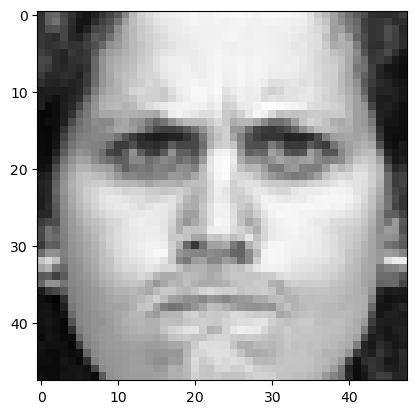

In [75]:
plt.imshow(X_train_Gabor[0]/255.0,cmap='gray')

In [76]:
X_train_Gabor=create_Gabor_features(X_train_Gabor)
X_test_Gabor=create_Gabor_features(X_test_Gabor)

X_train_Gabor.shape,X_test_Gabor.shape

((784, 48, 48, 1), (197, 48, 48, 1))

<Figure size 640x480 with 0 Axes>

(-0.5, 47.5, 47.5, -0.5)

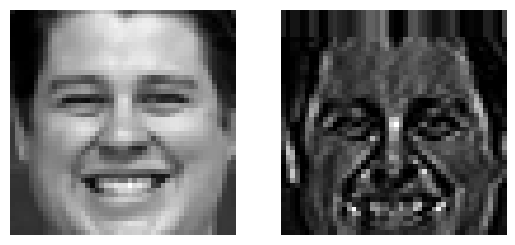

In [77]:
sample=random.randint(100,500)
plt.subplot(1,2,1)
plt.imshow(X_train[sample],cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(X_train_Gabor[sample],cmap='gray')
plt.axis('off')

In [78]:
X_train_Gabor.shape

(784, 48, 48, 1)

In [79]:
Gabor_model=create_model()
Gabor_model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [80]:
Gabor_history=Gabor_model.fit(X_train_Gabor,y_train,batch_size=8,epochs=50,validation_data=(X_test_Gabor,y_test),callbacks=[callbacks])

Epoch 1/50
98/98 [==============================] - 24s 29ms/step - loss: 1.6561 - accuracy: 0.4171 - val_loss: 1.9356 - val_accuracy: 0.1168 - lr: 0.0010
Epoch 2/50
98/98 [==============================] - 2s 21ms/step - loss: 1.0973 - accuracy: 0.6237 - val_loss: 1.9488 - val_accuracy: 0.1168 - lr: 0.0010
Epoch 3/50
98/98 [==============================] - 2s 21ms/step - loss: 0.9811 - accuracy: 0.6824 - val_loss: 1.9182 - val_accuracy: 0.1878 - lr: 0.0010
Epoch 4/50
98/98 [==============================] - 2s 20ms/step - loss: 0.8657 - accuracy: 0.6964 - val_loss: 1.9272 - val_accuracy: 0.1168 - lr: 0.0010
Epoch 5/50
98/98 [==============================] - 2s 23ms/step - loss: 0.7247 - accuracy: 0.7411 - val_loss: 1.7034 - val_accuracy: 0.2843 - lr: 0.0010
Epoch 6/50
98/98 [==============================] - 2s 22ms/step - loss: 0.7495 - accuracy: 0.7462 - val_loss: 0.8287 - val_accuracy: 0.6599 - lr: 0.0010
Epoch 7/50
98/98 [==============================] - 2s 22ms/step - loss: 0.

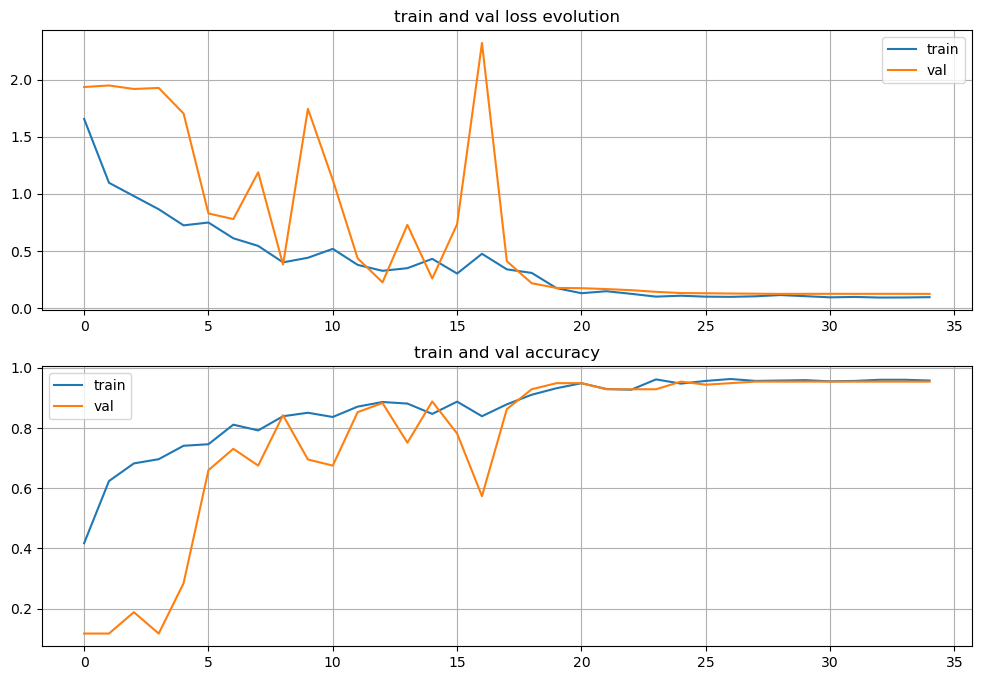

In [81]:
plot_performance(Gabor_history)

In [82]:
Gabor_acc=Gabor_model.evaluate(X_test_Gabor,y_test,verbose=0)[1]
acc.append(Gabor_acc)
print('Gabor Accuracy:',Gabor_model.evaluate(X_test_Gabor,y_test,verbose=0)[1])

Gabor Accuracy: 0.9543147087097168


In [83]:
Gabor_model.save('Gabor_model.h5')

# Without Feature Extraction

In [84]:
WFE_model=create_model()
WFE_model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [85]:
WFE_history=WFE_model.fit(X_train,y_train,batch_size=8,epochs=50,validation_data=(X_test,y_test),callbacks=[callbacks])

Epoch 1/50
98/98 [==============================] - 24s 30ms/step - loss: 1.5983 - accuracy: 0.4362 - val_loss: 1.9418 - val_accuracy: 0.1878 - lr: 0.0010
Epoch 2/50
98/98 [==============================] - 2s 20ms/step - loss: 1.1531 - accuracy: 0.5995 - val_loss: 1.9668 - val_accuracy: 0.0711 - lr: 0.0010
Epoch 3/50
98/98 [==============================] - 2s 20ms/step - loss: 1.0201 - accuracy: 0.6760 - val_loss: 2.0275 - val_accuracy: 0.1168 - lr: 0.0010
Epoch 4/50
98/98 [==============================] - 2s 24ms/step - loss: 0.9057 - accuracy: 0.7015 - val_loss: 2.0562 - val_accuracy: 0.1066 - lr: 0.0010
Epoch 5/50
98/98 [==============================] - 2s 21ms/step - loss: 0.7747 - accuracy: 0.7296 - val_loss: 2.0369 - val_accuracy: 0.0812 - lr: 0.0010
Epoch 6/50
98/98 [==============================] - 2s 21ms/step - loss: 0.6952 - accuracy: 0.7423 - val_loss: 0.8569 - val_accuracy: 0.6954 - lr: 0.0010
Epoch 7/50
98/98 [==============================] - 2s 21ms/step - loss: 0.

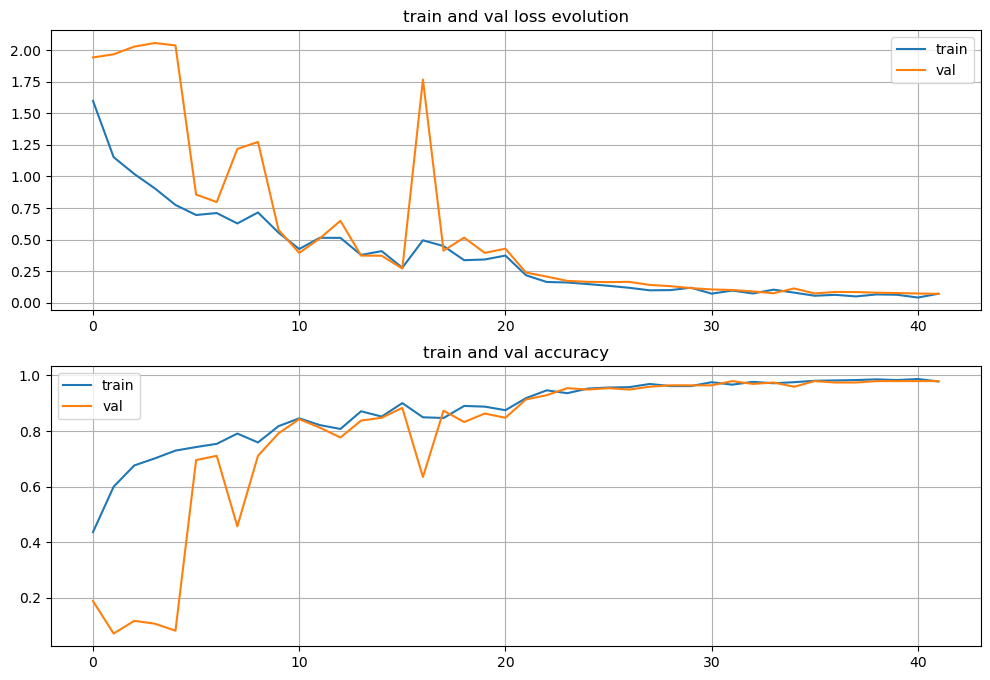

In [86]:
plot_performance(WFE_history)

In [87]:
WFE_acc=WFE_model.evaluate(X_test,y_test,verbose=0)[1]
acc.append(WFE_acc)
print("Without Feature extraction Accuracy : ",WFE_acc)

Without Feature extraction Accuracy :  0.9796954393386841


In [88]:
WFE_model.save('WFE_model.h5')

# Comparing Accuracies

In [89]:
acc

[0.989847719669342,
 0.9949238300323486,
 0.9593908786773682,
 0.9543147087097168,
 0.9796954393386841]

In [90]:
results=pd.DataFrame(acc,index=['HOG','LBP','SIFT','Gabor','Without Feature Extraction'],columns=['Accuracies'])

In [91]:
dfStyler=results.style.set_properties(**{'text-align':'left'})
dfStyler.set_table_styles([dict(selector='th',props=[('text-align','left')])])

# HOG-SVM

In [92]:
Feature_X_train.shape

(784, 48, 48, 1)

In [93]:
Feature_X_train[0].shape

(48, 48, 1)

In [94]:
X_train_HOG_Flat=np.zeros((len(X_train),48*48))
for i in range(len(Feature_X_train)):
    img=Feature_X_train[0]
    img=img.flatten()
    X_train_HOG_Flat[i]=img
X_train_HOG_Flat.shape

(784, 2304)

In [95]:
X_test_HOG_Flat=np.zeros((len(X_test),48*48))
for i in range(len(Feature_X_test)):
    img=Feature_X_test[0]
    img=img.flatten()
    X_test_HOG_Flat[i]=img
X_test_HOG_Flat.shape

(197, 2304)

In [96]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler=StandardScaler()
X_train_HOG_Flat=scaler.fit_transform(X_train_HOG_Flat)

In [97]:
X_train_HOG_Flat.shape

(784, 2304)

In [98]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.01,0.1],'kernel':['rbf','poly']}
svc=svm.SVC(probability=True,verbose=True)
model=GridSearchCV(svc,param_grid)

In [99]:
y_train_SVM.shape

(784, 1)

In [100]:
a=np.squeeze(y_train_SVM)
a.shape

(784,)

In [101]:
model.fit(X_train_HOG_Flat,a)

[LibSVM]*
optimization finished, #iter = 35
obj = -7.000000, rho = 1.000000
nSV = 70, nBSV = 70
Total nSV = 70
*
optimization finished, #iter = 35
obj = -7.000000, rho = 1.000000
nSV = 70, nBSV = 70
Total nSV = 70
*
optimization finished, #iter = 33
obj = -6.600000, rho = 1.000000
nSV = 66, nBSV = 66
Total nSV = 66
*
optimization finished, #iter = 36
obj = -7.200000, rho = 1.000000
nSV = 72, nBSV = 72
Total nSV = 72
*
optimization finished, #iter = 33
obj = -6.600000, rho = 1.000000
nSV = 66, nBSV = 66
Total nSV = 66
*
optimization finished, #iter = 43
obj = -8.600000, rho = -1.000000
nSV = 86, nBSV = 86
*
optimization finished, #iter = 42
obj = -8.400000, rho = 1.000000
nSV = 84, nBSV = 84
Total nSV = 84
*
optimization finished, #iter = 44
obj = -8.800000, rho = 1.000000
nSV = 88, nBSV = 88
Total nSV = 88
*
optimization finished, #iter = 43
obj = -8.600000, rho = 1.000000
nSV = 86, nBSV = 86
Total nSV = 86
*
optimization finished, #iter = 40
obj = -8.000000, rho = 1.000000
nSV = 80, n

GridSearchCV(estimator=SVC(probability=True, verbose=True),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [0.0001, 0.001, 0.01, 0.1],
                         'kernel': ['rbf', 'poly']})

In [102]:
from sklearn.metrics import accuracy_score
y_pred=model.predict(X_test_HOG_Flat)
accuracy_score(np.squeeze(y_test_SVM),y_pred)

0.2131979695431472

In [103]:
1-0.2131979695431472

0.7868020304568528

In [104]:
pca=PCA(n_components=2)
principalComponents=pca.fit_transform(X_train_HOG_Flat)

/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:642: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


In [105]:
principalComponents.shape

(784, 2)

# VGG

**Load base model**

In [106]:
# base_model=tf.keras.applications.VGG16(input_shape=(48,48,3),include_top=False,weights="imagenet")

In [107]:
# #Freezing layers
# for layer in base_model.layers[:4]:
#     layer.trainable=False

In [108]:
# np.random.seed(1)
# tf.random.set_seed(1)

# model=models.Sequential()
# model.add(layers.experimental.preprocessing.Resizing(224,224,interpolation="bilinear",input_shape=X_train.shape[1:]))

# model.add(layers.Conv2D(64,3,strides=1,padding='same'))
# model.add(layers.Activation('relu'))

# model.add(layers.Conv2D(64,3,strides=1,padding='same'))
# model.add(layers.Activation('relu'))
# model.add(layers.MaxPooling2D(2,strides=2))

# model.add(layers.Conv2D(128,3,strides=1,padding='same'))
# model.add(layers.Activation('relu'))

# model.add(layers.Conv2D(128,3,strides=1,padding='same'))
# model.add(layers.Activation('relu'))
# model.add(MaxPooling2D(2,strides=2))

# model.add(layers.Conv2D(256,3,strides=1,padding='same'))
# model.add(layers.Activation('relu'))

# model.add(layers.Conv2D(256,3,strides=1,padding='same'))
# model.add(layers.Activation('relu'))

# model.add(layers.Conv2D(256,1,strides=1,padding='same'))
# model.add(layers.Activation('relu'))
# model.add(MaxPooling2D(2,strides=2))

# model.add(layers.Conv2D(512,3,strides=1,padding='same'))
# model.add(layers.Activation('relu'))

# model.add(layers.Conv2D(512,3,strides=1,padding='same'))
# model.add(layers.Activation('relu'))

# model.add(layers.Conv2D(512,1,strides=1,padding='same'))
# model.add(layers.Activation('relu'))
# model.add(MaxPooling2D(2,strides=2))

# model.add(layers.Conv2D(512,3,strides=1,padding='same'))
# model.add(layers.Activation('relu'))

# model.add(layers.Conv2D(512,3,strides=1,padding='same'))
# model.add(layers.Activation('relu'))

# model.add(layers.Conv2D(512,1,strides=1,padding='same'))
# model.add(layers.Activation('relu'))
# model.add(layers.MaxPooling2D(2,strides=2))

# model.add(layers.Flatten())

# model.add(layers.Dense(4096,activation='relu'))
# model.add(layers.Dropout(0.5))

# model.add(layers.Dense(4096,activation='relu'))
# model.add(layers.Dropout(0.5))

# model.add(layers.Dense(10,activation='softmax'))

# model.summary()

# #vgg_model.trainable=False

# #tf.keras.utils.plot_model(vgg_model,show_shapes=True)
# #plot_model(vgg_model,to_file='VGG_model.png')

In [109]:
# base_model.summary()

In [110]:
# plot_model(base_model,to_file='VGG_model.png')

In [111]:
# #Building model

# model=Sequential()
# model.add(base_model)
# model.add(Dropout(0.5))
# model.add(Flatten())
# model.add(BatchNormalization())
# model.add(Dense(32,kernel_initializer='he_uniform'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(32,kernel_initializer='he_uniform'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(32,kernel_initializer='he_uniform'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dense(7,activation='softmax'))

In [112]:
# #model summary
# model.summary()

In [113]:
# from IPython.display import Image
# plot_model(model,to_file='convnet.png',show_shapes=True,show_layer_names=True)
# Image(filename='convnet.png')

In [114]:
# def f1_score(y_true,y_pred): #taken fro  old keras source code
#     true_positives=K.sum(K.round(K.clip(y_true*y_pred,0,1)))
#     possible_positives=K.sum(K.round(K.clip(y_true,0,1)))
#     predicted_positives=K.sum(K.round(K.clip(y_pred,0,1)))
#     precision=true_positives/(predicted_positives+K.epsilon())
#     recall=true_positives/(possible_positives+K.epsilon())
#     f1_val=2*(precision*recall)/(precision+recall+K.epsilon())
#     return f1_val

In [115]:
# METRICS=[
#     tf.keras.metrics.BinaryAccuracy(name='accuracy'),
#     tf.keras.metrics.Precision(name='precision'),
#     tf.keras.metrics.Recall(name='recall'),
#     tf.keras.metrics.AUC(name='auc'),
#       f1_score,
# ]

In [116]:
# lrd=ReduceLROnPlateau(monitor='val_loss',patience=20,verbose=1,factor=0.50,min_lr=0.00005)
# mcp=ModelCheckpoint('model_vgg.h5')
# es1=EarlyStopping(verbose=1,patience=20)

In [117]:
# model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=METRICS)

In [118]:
# X_train_vgg=X_train
# X_test_vgg=X_test
# y_train_vgg=y_train
# y_test_vgg=y_test

In [119]:
# train_dataset=pd.concat([X_train,y_train],axis=1)

In [120]:
# vgg_history=model.fit(X_train,batch_size=8,epochs=50,validation_data=(X_test,y_test),callbacks=[lrd,mcp,es1])

**Plotting results**

In [121]:
# def Train_Val_Plot(accu,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
#     fig,(ax1,ax2,ax3,ax4,ax5)=plt.subplots(1,5,figsize=(20,5))
#     fig.subtitle("Model's metrics visualization ")
    
#     ax1.plot(range(1,len(accu)+1),accu)
#     ax1.plot(range(1,len(val_acc)+1),val_acc)
#     ax1.set_title("History of Accuracy")
#     ax1.set_xlabel('Epochs')
#     ax1.set_ylabel('Accuracy')
#     ax1.legend(['training','validation'])
    
#     ax2.plot(range(1,len(loss)+1),loss)
#     ax2.plot(range(1,len(val_loss)+1),val_loss)
#     ax2.set_title("History of Loss")
#     ax2.set_xlabel('Epochs')
#     ax2.set_ylabel('Loss')
#     ax2.legend(['training','validation'])
    
#     ax3.plot(range(1,len(auc)+1),auc)
#     ax3.plot(range(1,len(val_auc)+1),val_auc)
#     ax3.set_title("History of AUC")
#     ax3.set_xlabel('Epochs')
#     ax3.set_ylabel('AUC')
#     ax3.legend(['training','validation'])
    
#     ax4.plot(range(1,len(precision)+1),precision)
#     ax4.plot(range(1,len(val_precision)+1),val_precision)
#     ax4.set_title("History of Precision")
#     ax4.set_xlabel('Epochs')
#     ax4.set_ylabel('Precision')
#     ax4.legend(['training','validation'])
    
#     ax5.plot(range(1,len(f1)+1),f1)
#     ax5.plot(range(1,len(val_f1)+1),val_f1)
#     ax5.set_title("History of F1-score")
#     ax5.set_xlabel('Epochs')
#     ax5.set_ylabel('F1 score')
#     ax5.legend(['training','validation'])
    
#     plt.show()
    
# Train_Val_Plot(history.history['accuracy'],vgg_history.history['val_accuracy'],
#                history.history['loss'],vgg_history.history['val_loss'],
#                history.history['auc'],vgg_history.history['val_auc'],
#                history.history['precision'],vgg_history.history['val_precision'],
#                history.history['f1_score'],vgg_history.history['val_f1_score'],
#               )

**Train run 1**

In [122]:
# history = head_model.fit(X_train, y_train, batch_size=64, epochs=40, validation_data=(X_test, y_test))

In [123]:
# history=vgg_history.history
# print(history.keys())

In [124]:
# epoch_range=range(1,len(history['loss'])+1)

# plt.figure(figsize=[14,4])
# plt.subplot(1,2,1)
# plt.plot(epoch_range,history['loss'],label='Training')
# plt.plot(epoch_range,history['val_loss'],label='Validation')
# plt.xlabel('Epoch');plt.ylabel('Loss');plt.title('Loss')
# plt.legend()
# plt.subplot(1,2,2)
# plt.plot(epoch_range,history['accuracy'],label='Training')
# plt.plot(epoch_range,history['val_accuracy'],label='Validation')
# plt.xlabel('Epoch');plt.ylabel('Accuracy');plt.title('Accuracy')
# plt.legend()
# plt.tight_layout()
# plt.show()

**Train run #2**

In [125]:
# tf.keras.backend.set_value(cnn.optimizer.learning_rate,0.0001)

In [126]:
# %%time

# vgg_history1=cnn.fit(
#     X_train_vgg,y_train,
#     batch_size=32,
#     epochs=20,
#     verbose=1,
#     validation_data=(X_test_vgg,y_test)
# )

In [127]:
# for k in history.keys():
#     history[k]+=vgg_history1.history[k]

# epoch_range=range(1,len(history['loss'])+1)

# plt.figure(figsize=[14,4])
# plt.subplot(1,2,1)
# plt.plot(epoch_range,history['loss'],label='Training')
# plt.plot(epoch_range,history['val_loss'],label='Validation')
# plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
# plt.legend()
# plt.subplot(1,2,2)
# plt.plot(epoch_range,history['accuracy'],label='Training')
# plt.plot(epoch_range,history['val_accuracy'],label='Validation')
# plt.xlabel('Epoch');plt.ylabel('Accuracy');plt.title('Accuracy')
# plt.legend()
# plt.tight_layout()
# plt.show()

**Training run #3**

In [128]:
# tf.keras.backend.set_value(cnn.optimizer.learning_rate,0.00001)

In [129]:
# %%time

# vgg_history2=cnn.fit(
#     X_train_vgg,y_train,
#     batch_size=32,
#     epochs=20,
#     verbose=1,
#     validation_data=(X_test_vgg,y_test)
# )

In [130]:
# for k in history.keys():
#     history[k]+=vgg_history2.history[k]
    
# epoch_range=range(1,len(history['loss'])+1)

# plt.figure(figsize=[14,4])
# plt.subplot(1,2,1)
# plt.plot(epoch_range,history['loss'],label='Training')
# plt.plot(epoch_range,history['val_loss'],label='Validation')
# plt.xlabel('Epoch');plt.ylabel('Loss');plt.title('Loss')
# plt.legend()
# plt.subplot(1,2,2)
# plt.plot(epoch_range,history['accuracy'],label='Training')
# plt.plot(epoch_range,history['val_accuracy'],label='Validation')
# plt.xlabel('Epoch');plt.ylabel('Accuracy');plt.title('Accuracy')
# plt.legend()
# plt.tight_layout()
# plt.show()

In [131]:
# vgg_acc=cnn.evaluate(X_test_vgg,y_test,verbose=0)[1]
# acc.append(vgg_acc)
# print("VGG Accuracy: ",vgg_acc)

**Save Model**

In [132]:
# cnn.save('vgg_model.h5')